# Likelihood (3DP3) constrained to rays

In [49]:
import jax
from jax import (jit, vmap)
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import genjax

In [50]:
from scipy.stats import truncnorm as scipy_truncnormal

normal_logpdf = jax.scipy.stats.norm.logpdf
truncnorm_pdf = jax.scipy.stats.truncnorm.pdf
truncnorm_logpdf = jax.scipy.stats.truncnorm.logpdf
logsumexp = jax.scipy.special.logsumexp


In [51]:
def constrained_lh_mix(x, ys, zmax=100.0, sig=0.1):
    z = jnp.linalg.norm(x)

    zs_ = ys @ x / z
    ws_ = jnp.linalg.norm(zs_[...,None] * x/z - ys, axis=-1)
    ws_ = normal_logpdf(ws_, loc=0.0, scale=sig)
    ws_ = ws_ - logsumexp(ws_)


    logps = jnp.log(truncnorm_pdf(z, (0.0 - zs_)/sig, (zmax - zs_)/sig, loc=zs_, scale=sig))
    logp  = logsumexp(logps + ws_)

    return logp


def constrained_lh_mix_ij(i,j, X, Y_padded, zmax=100.0, sig=0.1, w=7):
    x  = X[i, j, :3]
    ys = jax.lax.dynamic_slice(Y_padded, (i, j, 0), (2*w + 1, 2*w + 1, 3))
    return constrained_lh_mix(x, ys, zmax=100.0, sig=0.1)


def constrained_lh(X,Y, zmax, sig, w):
    Y_ = jax.lax.pad(Y,  -100., ((w,w,0,),(w,w,0,),(0,0,0,)))
    J, I = jnp.meshgrid(jnp.arange(X.shape[1]), jnp.arange(X.shape[0]))

    f_ij = lambda i,j: constrained_lh_mix_ij(i, j, X, Y_, zmax, sig, w) 
    logps = jax.vmap(f_ij)(I, J)
    return logps.sum()

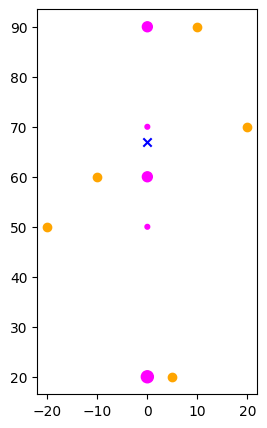

In [52]:
zmax = 100.0
sig = 10.0

x  = jnp.array([0.,67.,0.])
ys = jnp.array([ 
    [-20, 50, 0],
    [-10, 60, 0],
    [10, 90, 0],
    [20, 70, 0],
    [5, 20, 0],
])


z = jnp.linalg.norm(x)

zs_ = ys @ x / z
ws_ = jnp.linalg.norm(zs_[...,None] * x/z - ys, axis=-1)
ws_ = normal_logpdf(ws_, loc=0.0, scale=sig)
ws_ = ws_ - logsumexp(ws_)
logps = truncnorm_logpdf(z, (0.0 - zs_)/sig, (zmax - zs_)/sig, loc=zs_, scale=sig)
logp  = logsumexp(logps + ws_)


vs = zs_[...,None] * x/z



# ------------------------------
plt.figure(figsize=(5,5))
plt.gca().set_aspect(1)
plt.scatter(ys[:,0], ys[:,1], c="orange")
plt.scatter(vs[:,0], zs_,  s=jnp.exp(ws_)*2_00, c="magenta")
plt.scatter(x[0], z, marker="x", c="blue");

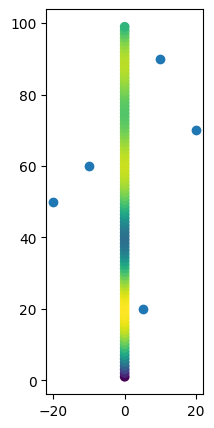

In [53]:
xs = jnp.linspace(0.0, zmax, 100)[:,None] * x/z


ps = vmap(lambda x: constrained_lh_mix(x, ys, zmax=100.0, sig=10.))(xs)

plt.figure(figsize=(5,5))
plt.gca().set_aspect(1)
plt.scatter(xs[:,0], xs[:,1], c = ps)
plt.scatter(ys[:,0], ys[:,1])

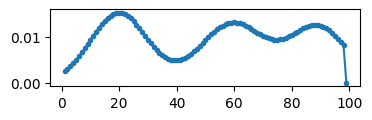

In [54]:
plt.figure(figsize=(4,1))
plt.plot(jnp.exp(ps), marker=".")

In [55]:
imgs = []
for t in range(10):
    im = np.load(f"./data/test_imgs/img_{t}.npy")
    imgs.append(jnp.array(im))

imgs = jnp.array(imgs)
imgs.shape

(10, 100, 200, 4)

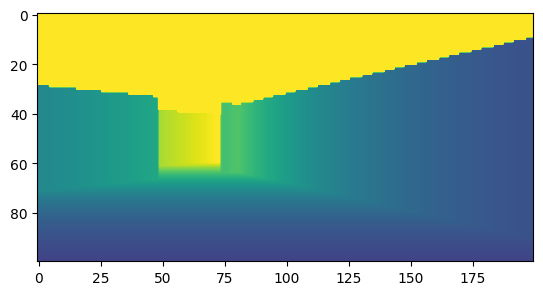

In [37]:
plt.imshow(imgs[2,:,:,2], vmin=0., vmax=5)

In [48]:
zmax = 100.0
sig = 0.1
w = 7

X = imgs[2]
Y = imgs[1]
# constrained_lh(X,Y, zmax, sig, w)

J, I = jnp.meshgrid(jnp.arange(X.shape[1]), jnp.arange(X.shape[0]))
I.shape, J.shape
jj, ii = jnp.meshgrid(jnp.arange(X.shape[1]), jnp.arange(X.shape[0]))
indices = jnp.stack([ii,jj],axis=-1)
indices.shape

(100, 200, 2)